# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import nbformat
from nbconvert import HTMLExporter
import copy
import os


# How to use
This is a notebook to compare and visualize results of two benchamrks of the same type.
To perform the analysis please provide a benchamrk results csv files paths as a `path1` and `path2` in User input section. You can also specify a name of resulting HTML file as a `filename` in the same section and name the benchmarks by modifying `benchmark_1_name` and `benchmark_2_name`. To perform the analysis provide the neccessary user input and run the notebook. The results will be converted to HTML and saved in `data_analysis_results` folder. You can convert the given HTML to PDF in your browser to add notes and comments

# User input

## Defining benchmark file path

In [2]:
path1 = "benchmark_results/2024-11-08_15-34-06/altered.csv"
path2 = "benchmark_results/2024-11-08_15-34-06/test.csv"

## (optional) Define data analysis file name

In [3]:
benchmark_1_name = None
benchmark_2_name = None
filename = None

In [4]:
if benchmark_1_name is None:
    benchmark_1_name = path1.split("/")[-1]
    benchmark_1_name = benchmark_1_name.split(".")[0]
if benchmark_2_name is None:
    benchmark_2_name = path2.split("/")[-1]
    benchmark_2_name = benchmark_2_name.split(".")[0]
if filename is None:
    filename = benchmark_1_name + "_vs_" + benchmark_2_name + "_analysis"

# Preprocessing

In [5]:
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m + s / 60

def seconds_to_miliseconds(seconds):
    return seconds * 1000

In [6]:
def process_df(df1):
    df1['found route duration (min)'] = df1['found route duration'].apply(time_to_minutes)
    df1['Label'] = df1['Start name'] + ' -> ' + df1['Destination Name'] + '\n (' + df1['Start Time'] + ' '+ df1['Day of week'] + ')'
    df1['get_next_trips_time_total'] = df1['get_next_trips_time_total'].apply(seconds_to_miliseconds)
    df1['plan_compute_heurstic_time_total'] = df1['plan_compute_heurstic_time_total'].apply(seconds_to_miliseconds)
    df1['plan_compute_actual_time_total'] = df1['plan_compute_actual_time_total'].apply(seconds_to_miliseconds)
    df1['find_plans_time_total'] = df1['find_plans_time_total'].apply(seconds_to_miliseconds)
    df1['planner_initialization_time'] = df1['planner_initialization_time'].apply(seconds_to_miliseconds)
    df1['start_walking_times_time'] = df1['start_walking_times_time'].apply(seconds_to_miliseconds)
    df1['destination_walking_times_time'] = df1['destination_walking_times_time'].apply(seconds_to_miliseconds)
    df1['precomputed_heurisitc_times_time'] = df1['precomputed_heurisitc_times_time'].apply(seconds_to_miliseconds)
    return df1

In [7]:
df1 = pd.read_csv(path1, encoding = "ISO-8859-2")
df2 = pd.read_csv(path2, encoding = "ISO-8859-2")

df1 = process_df(df1)
df2 = process_df(df2)

df1['difference (min)'] = df2['found route duration (min)'] - df1['found route duration (min)']
df1['difference_find_plans_time'] = df2['find_plans_time_total'] - df1['find_plans_time_total']

num_rows = len(df1)
fig_height = num_rows / 3.8


# Plots

In [8]:
def compare_columns(column_name, title, xlabel, ax, show_labels=True):
    label_column='Label'
    ylabel='Route',
    df1[f'difference_{column_name}'] = df2[column_name] - df1[column_name]

    df1['Label'] = df1[label_column]

    bars = ax.barh(df1['Label'], df1[f'difference_{column_name}'].fillna(0), color=['green' if x > 0 else 'red' if x < 0 else 'gray' for x in df1[f'difference_{column_name}'].fillna(0)], linewidth=1.5)

    for bar in bars:
        bar.set_edgecolor('white')
        bar.set_linewidth(1)
        bar.set_path_effects([])
        bar.set_clip_on(False)
        bar.set_capstyle('round')

    if show_labels:
        #ax.set_ylabel(ylabel)
        ax.set_yticklabels(df1['Label'], fontsize=8)
    else:
        ax.set_yticklabels([])

    ax.set_xlabel(xlabel)
    ax.set_title(title)

    for i, (bar, diff) in enumerate(zip(bars, df1[f'difference_{column_name}'])):
        xval = bar.get_width()
        offset = 0 
        color = 'green' if xval > 0 else 'red' if xval < 0 else 'gray'
        if pd.isna(diff):
            ax.text(0, bar.get_y() + bar.get_height()/2, 'NA', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
        else:
            if xval > 0:
                ax.text(xval + offset, bar.get_y() + bar.get_height()/2, round(xval), ha='left', va='center', color='black', fontsize=10, fontweight='bold')
            else:
                ax.text(xval - offset, bar.get_y() + bar.get_height()/2, round(xval), ha='right', va='center', color='black', fontsize=10, fontweight='bold')

    ax.grid(axis='x', linestyle='--', alpha=0.7)

## Performance comparison

C:\Users\User\AppData\Local\Temp\ipykernel_15460\1170113160.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(df1['Label'], fontsize=8)
C:\Users\User\AppData\Local\Temp\ipykernel_15460\1170113160.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(df1['Label'], fontsize=8)
C:\Users\User\AppData\Local\Temp\ipykernel_15460\1170113160.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(df1['Label'], fontsize=8)


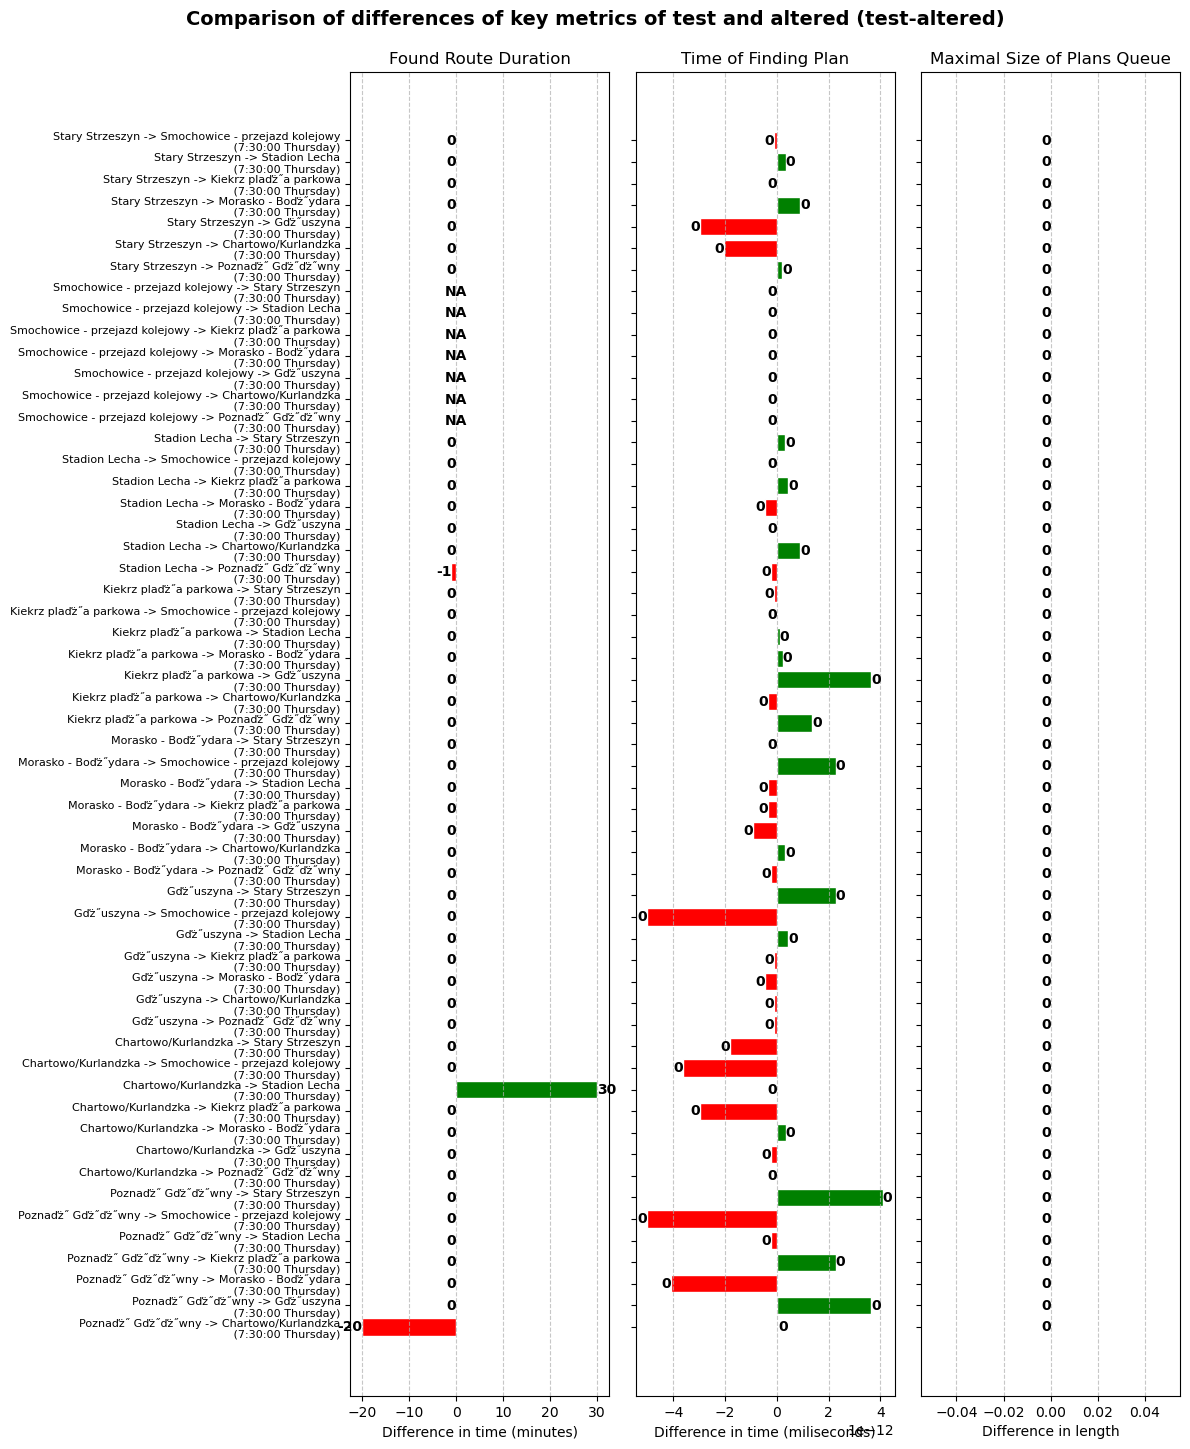

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12, fig_height), sharey=True)
compare_columns(
    column_name='found route duration (min)', 
    title='Found Route Duration', 
    xlabel='Difference in time (minutes)', 
    ax=axes[0],
)

compare_columns( 
    column_name='find_plans_time_total', 
    title='Time of Finding Plan', 
    xlabel='Difference in time (miliseconds)', 
    ax=axes[1],
)

compare_columns( 
    column_name='plans_queue_max_size', 
    title='Maximal Size of Plans Queue', 
    xlabel='Difference in length', 
    ax=axes[2],
)

fig.suptitle(f'Comparison of differences of key metrics of {benchmark_2_name} and {benchmark_1_name} ({benchmark_2_name}-{benchmark_1_name})\n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Searching time components

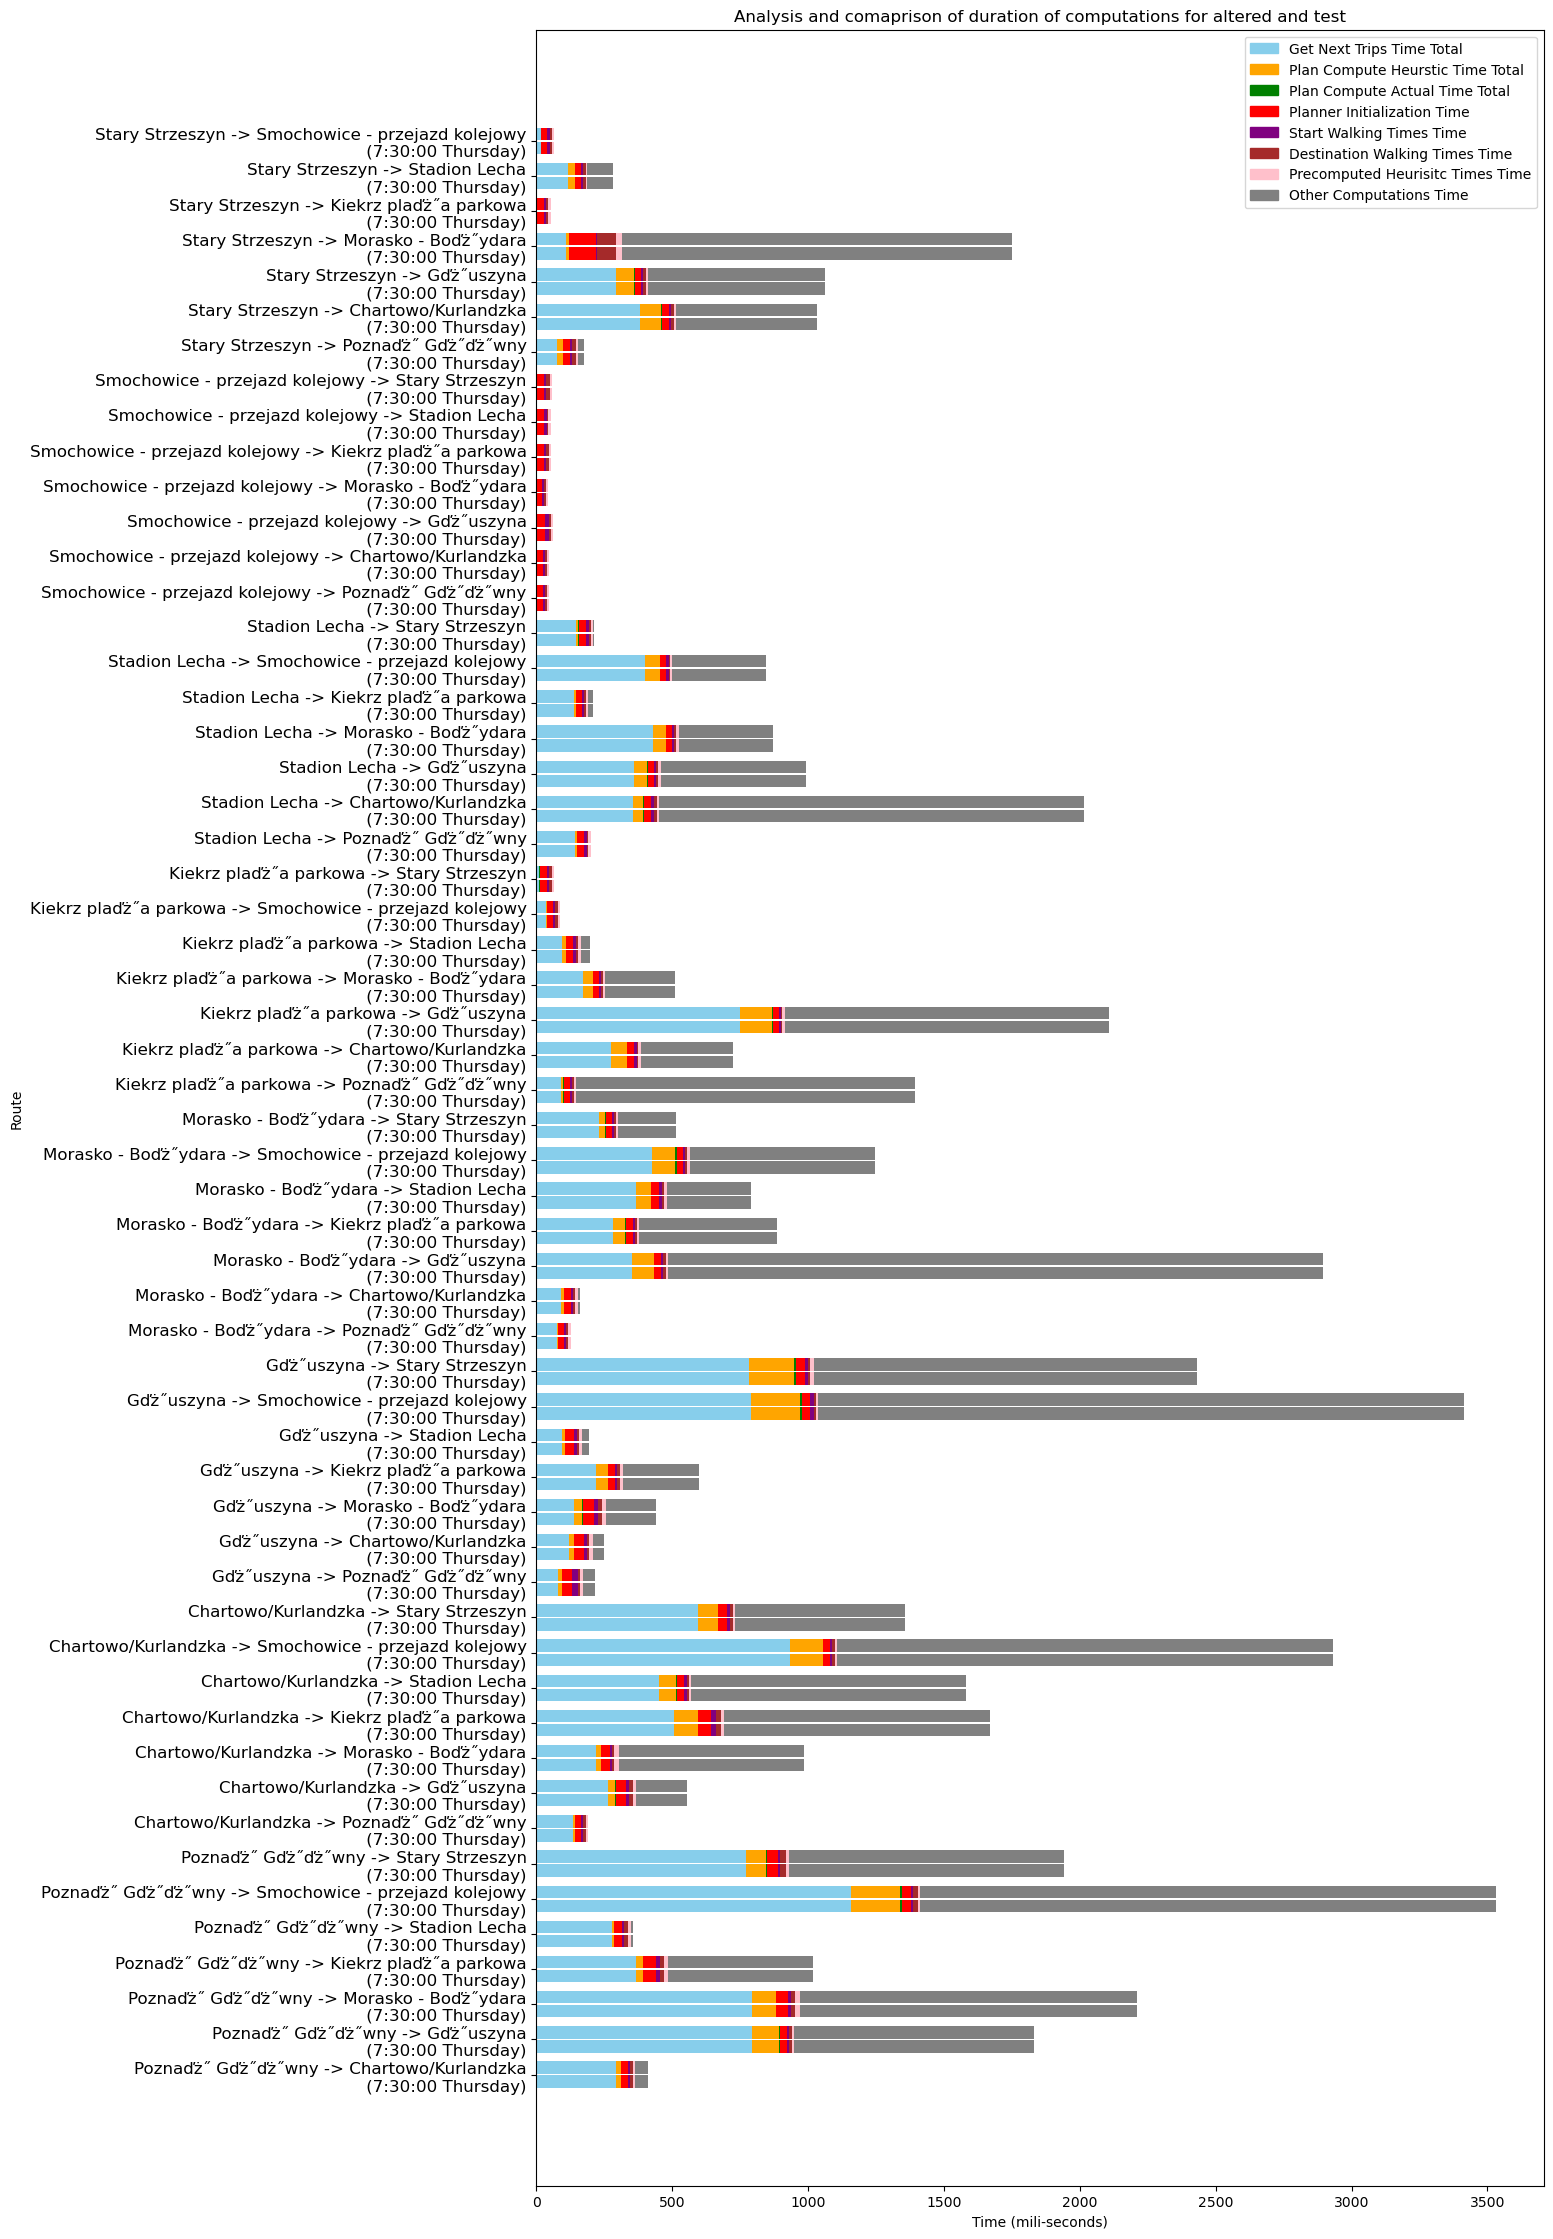

In [ ]:
# Define the columns to be used
columns = [
    'get_next_trips_time_total',
    'plan_compute_heurstic_time_total',
    'plan_compute_actual_time_total',
    'planner_initialization_time',
    'start_walking_times_time',
    'destination_walking_times_time',
    'precomputed_heurisitc_times_time'
]

# Calculate the "other_computations_time" segment for both DataFrames
df1['other_computations_time'] = df1['find_plans_time_total'] - df1[columns].sum(axis=1, skipna=True)
df2['other_computations_time'] = df2['find_plans_time_total'] - df2[columns].sum(axis=1, skipna=True)

# Ensure no negative values in "other_computations_time"
df1['other_computations_time'] = df1['other_computations_time'].apply(lambda x: max(x, 0))
df2['other_computations_time'] = df2['other_computations_time'].apply(lambda x: max(x, 0))

# Define a color map for the segments
color_map = {
    'get_next_trips_time_total': 'skyblue',
    'plan_compute_heurstic_time_total': 'orange',
    'plan_compute_actual_time_total': 'green',
    'planner_initialization_time': 'red',
    'start_walking_times_time': 'purple',
    'destination_walking_times_time': 'brown',
    'precomputed_heurisitc_times_time': 'pink',
    'other_computations_time': 'gray'
}

# Plotting
fig, ax = plt.subplots(figsize=(13, fig_height*2))

# Bar positions
bar_width = 0.35
gap_between_benchmarks = 0.05
index = np.arange(len(df1))

# Plot stacked bars for the first benchmark
bottom1 = pd.Series([0] * len(df1))
for column in columns:
    if column in df1:
        ax.barh([i - bar_width/2 - gap_between_benchmarks/2 for i in index], df1[column], bar_width, left=bottom1, color=color_map[column], label=column.replace('_', ' ').title() if column == columns[0] else "")
        bottom1 += df1[column]
ax.barh([i - bar_width/2 - gap_between_benchmarks/2 for i in index], df1['other_computations_time'], bar_width, left=bottom1, color=color_map['other_computations_time'], label='Other Computations Time' if 'other_computations_time' == columns[0] else "")

# Plot stacked bars for the second benchmark
bottom2 = pd.Series([0] * len(df2))
for column in columns:
    if column in df2:
        ax.barh([i + bar_width/2 + gap_between_benchmarks/2 for i in index], df2[column], bar_width, left=bottom2, color=color_map[column], label=column.replace('_', ' ').title() if column == columns[0] else "")
        bottom2 += df2[column]
ax.barh([i + bar_width/2 + gap_between_benchmarks/2 for i in index], df2['other_computations_time'], bar_width, left=bottom2, color=color_map['other_computations_time'], label='Other Computations Time' if 'other_computations_time' == columns[0] else "")

# Add labels and title
plt.xlabel('Time (mili-seconds)')
plt.ylabel('Route')
plt.title(f'Analysis and comaprison of duration of computations for {benchmark_1_name} and {benchmark_2_name}')

# Create custom legend
handles = [plt.Rectangle((0,0),1,1, color=color_map[col]) for col in columns + ['other_computations_time']]
labels = [col.replace('_', ' ').title() for col in columns + ['other_computations_time']]
ax.legend(handles, labels)

# Set y-ticks and labels
ax.set_yticks(index)
ax.set_yticklabels(df1['Label'], fontsize=12)  # Increase the font size of the route labels

plt.show()

# Saving analysis to PDF

In [ ]:
# Load the current notebook
notebook_filename = 'two_benchmarks_comparison.ipynb'
with open(notebook_filename) as f:
    nb = nbformat.read(f, as_version=4)

# Create a deep copy of the notebook to modify for export
nb_copy = copy.deepcopy(nb)

# Remove inputs of cells with 'hide_code' or 'hide_markdown' tags in the copy
nb_copy['cells'] = [cell for cell in nb_copy['cells'] if not (
    'tags' in cell['metadata'] and
    ('hide_all' in cell['metadata']['tags'] or 'hide_markdown' in cell['metadata']['tags'])
)]
for cell in nb_copy['cells']:
    if 'tags' in cell['metadata']:
        if 'hide_code' in cell['metadata']['tags']:
            cell['source'] = ''  # Clear the source to hide the input

# Configure the HTML exporter
html_exporter = HTMLExporter()

# Export the modified notebook copy to HTML
html_data, resources = html_exporter.from_notebook_node(nb_copy)

# Create the directory if it does not exist
output_dir = 'data_analysis_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the HTML to a file in the specified directory
html_filename = os.path.join(output_dir, filename + '.html')
with open(html_filename, 'w') as f:
    f.write(html_data)

print(f'Notebook has been converted to HTML and saved as {html_filename}')

Notebook has been converted to HTML and saved as data_analysis_results\custom_benchmark_results2024-11-08_15-33-13-analysis.html
